# Homework2 - Generative Adversarial Network
This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this section, you are required to build a generative adversarial network for image generation.

If you have any question, contact TA via 1999joehuang@gmail.com


Sample code for DCGAN, include the structure and train function.
You can start form this file or write your own structure and train function.
You can also modify anything in this file for training.

What you need to do:
1. Load your dataset
2. Train the DCGAN models.
3. Plot the generator and discriminator loss.
4. Generate images in 5*5 grid.
5. Interpolate the z vector and genrate images in 3*10 grid.

For more details, please reference to DCGANPractice.pdf.

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


If you not familiar with Colab, [here](https://colab.research.google.com/drive/1GYNIgctFaYsxyuK2RqfRda1M0Qk-jhvL#scrollTo=enB7U8b9Z1WA) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment


### Packages Installation

In [1]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

### Download the dataset

You only need to use anime face dataset to train your model.

Download dataset via **gdown**.

Or you can download datasets from google drive.

Anime Face dataset: https://drive.google.com/file/d/1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ/view?usp=drive_link


In [2]:
# Anime Face dataset
!pip install gdown
!gdown --id 1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ --output "{workspace_dir}/anime_face.zip"

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ
From (redirected): https://drive.google.com/uc?id=1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ&confirm=t&uuid=a118f67d-2543-42f4-8739-c01865eb1669
To: /kaggle/working/anime_face.zip
100%|████████████████████████████████████████| 229M/229M [00:06<00:00, 36.6MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like:
```
dataset/
  anime_face_dataset/
    data/
      ├── 1.png
      ├── 2.png
      ├── 3.png
      ├── ...
```

In [3]:
# overwrite existing files without prompting.
!unzip -o -q "{workspace_dir}/anime_face.zip" -d "{workspace_dir}/anime_face_dataset"

# Random seed
Set the random seed to a certain value for reproducibility.

In [4]:
import random

import torch
import numpy as np

def same_seeds(seed):
  # Python built-in random module
  random.seed(seed)
  # Numpy
  np.random.seed(seed)
  # Torch
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(999)

# Import Packages

First, we need to import packages that will be used later.

In [5]:
import os
import glob

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Hyperparameters and Initialization
Let’s define some inputs for the run later:


In [6]:
# Root directory for dataset
dataroot = "anime_face_dataset"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 64
# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
# ngf = 64
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 100
# Learning rate for optimizers
lr = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# log(img) and checkpoints directory
log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Dataset

In [7]:
def get_dataset(dataroot):
  dataset = dset.ImageFolder(root=dataroot,
                transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.CenterCrop(image_size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]))
  return dataset

# Create the dataset
dataset = get_dataset(os.path.join(workspace_dir, dataroot))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

### Show some images

Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

It can be done by set **normalize=True** in torchvision.utils.make_grid function or manually shift [-1, 1] to [0, 1] by ```image = (image+1)/2``` for each image.

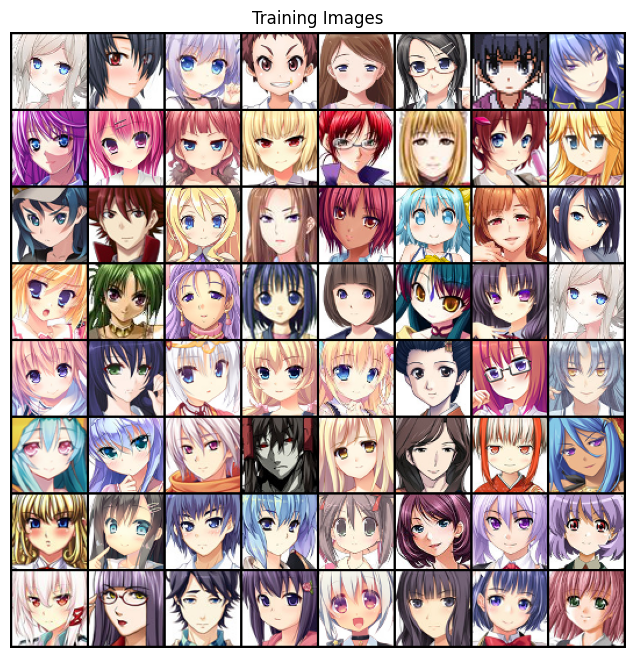

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model

Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the N of the input/output shape stands for the batch size.

<br/>

### Weight Initialization


In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

### Generator

In [10]:
class Generator(nn.Module):
  """
  Input shape: (N, in_dim, 1, 1)
  Output shape: (N, nc, image_size, image_size)

  In our sample code, input/output shape are:
    Input shape: (N, 100, 1, 1)
    Output shape: (N, 3, 64, 64)
  """

  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # Input is Z, going into a convolution
      nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),
      # State size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # State size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # State size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # State size. (ngf) x 32 x 32
      nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # State size. (nc) x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

### Discriminator

In [11]:
class Discriminator(nn.Module):
  """
  Input shape: (N, nc, image_size, image_size)
  Output shape: (N, )

  In our sample code, input/output are:
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
  """
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # Input is (nc) x 64 x 64
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf) x 32 x 32
      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*2) x 16 x 16
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*4) x 8 x 8
      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*8) x 4 x 4
      nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

# Train


### Initialization

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training loop

Starting Training Loop...


  Iters     Elapsed Time       Speed    Loss_D  Loss_G   Epoch  Step            
 334/334  00:00:28<00:00:00  11.57it/s  0.7172  13.6845    1    333             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_001.jpg.


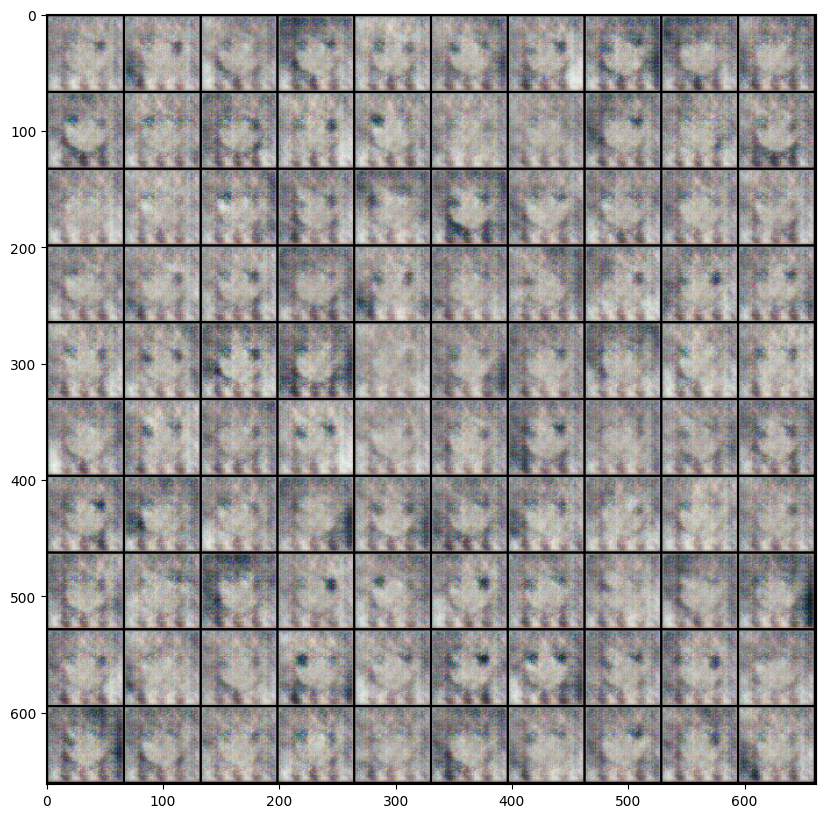

  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.212   6.3596    2    667              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_002.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.1291  3.4826    3    1001             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_003.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.342   6.3777    4    1335             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_004.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.0355  2.7986    5    1669             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_005.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.1789  4.554     6    2003             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_006.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.1418  5.5309    7    2337             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_007.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.2375  7.0658    8    2671             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_008.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1649  4.8332    9    3005             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_009.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.148   6.5654   10    3339             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_010.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1799  5.5394   11    3673             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_011.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1635  5.5877   12    4007             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_012.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.2714  4.8891   13    4341             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_013.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.07it/s  0.1632  6.0771   14    4675             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_014.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.1665  4.8861   15    5009             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_015.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.2202  4.0521   16    5343             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_016.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.2477  6.5495   17    5677             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_017.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.173   4.9317   18    6011             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_018.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1927  6.0994   19    6345             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_019.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.1988  3.7788   20    6679             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_020.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.2062  4.6795   21    7013             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_021.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.07it/s  0.2365  4.7574   22    7347             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_022.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.4149  3.7024   23    7681             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_023.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.1723  4.3688   24    8015             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_024.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.2021  4.3461   25    8349             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_025.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.2348  3.2396   26    8683             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_026.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.4903  2.6647   27    9017             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_027.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.3489  2.4877   28    9351             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_028.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.1934  4.5402   29    9685             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_029.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.466   5.5695   30    10019            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_030.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1767  4.1956   31    10353            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_031.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1672  3.5665   32    10687            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_032.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.2083  3.7423   33    11021            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_033.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.07it/s  0.167   3.2826   34    11355            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_034.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.4223  6.6983   35    11689            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_035.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.2137  4.0649   36    12023            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_036.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.1714  3.1824   37    12357            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_037.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.07it/s  0.1384  3.5991   38    12691            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_038.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.1162  3.4961   39    13025            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_039.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.203   4.6001   40    13359            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_040.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.1772  4.3575   41    13693            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_041.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.1325  4.0422   42    14027            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_042.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.97it/s  0.2411  4.1332   43    14361            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_043.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.2171  2.842    44    14695            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_044.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.02it/s  0.1171  3.8022   45    15029            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_045.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.1104  3.3093   46    15363            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_046.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.1439  3.5753   47    15697            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_047.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  1.5387  9.9958   48    16031            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_048.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.3487  3.2399   49    16365            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_049.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1554  4.5069   50    16699            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_050.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.0805  4.7192   51    17033            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_051.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1893  4.9106   52    17367            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_052.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.1326  4.2094   53    17701            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_053.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s   0.2    2.5328   54    18035            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_054.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.02it/s  0.1309  4.3121   55    18369            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_055.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.02it/s  0.0687  4.9492   56    18703            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_056.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1552  4.9696   57    19037            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_057.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  1.0587  8.3603   58    19371            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_058.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1616  4.5325   59    19705            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_059.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.0691  4.7586   60    20039            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_060.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.0505  4.7921   61    20373            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_061.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.1236  4.5865   62    20707            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_062.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.076   4.1907   63    21041            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_063.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.04it/s  0.1433  3.925    64    21375            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_064.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.02it/s  0.2924  7.6346   65    21709            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_065.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.1213  3.8777   66    22043            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_066.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.0781  4.6284   67    22377            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_067.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.2128  3.9603   68    22711            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_068.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.0408  5.8323   69    23045            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_069.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.1204  5.1207   70    23379            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_070.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.06it/s  0.0584  4.238    71    23713            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_071.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1104  2.9858   72    24047            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_072.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.1075  3.4205   73    24381            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_073.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.05it/s  0.0685  4.7401   74    24715            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_074.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.0992  5.4557   75    25049            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_075.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.0579  5.4526   76    25383            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_076.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  2.0263  1.8188   77    25717            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_077.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.03it/s  0.1348  6.0022   78    26051            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_078.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.0911  3.6576   79    26385            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_079.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.00it/s  0.0419  4.8011   80    26719            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_080.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.02it/s  0.0362  4.8654   81    27053            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_081.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  14.01it/s  0.3936  6.1811   82    27387            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_082.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.99it/s  0.3319  2.467    83    27721            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_083.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.98it/s  0.0891  4.7839   84    28055            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_084.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.95it/s  0.032   4.777    85    28389            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_085.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.98it/s  0.2365  3.2838   86    28723            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_086.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.95it/s  0.0714  5.2779   87    29057            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_087.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.96it/s  0.047   4.4256   88    29391            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_088.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.94it/s  0.6698  3.9518   89    29725            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_089.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.97it/s  0.1019  5.0033   90    30059            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_090.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.93it/s  0.0753  5.5303   91    30393            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_091.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.95it/s  0.0396  5.4799   92    30727            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_092.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.95it/s  0.036   4.7516   93    31061            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_093.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.97it/s  0.0353  4.7688   94    31395            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_094.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.95it/s  1.7979  1.3282   95    31729            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_095.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.97it/s  0.0473  5.4723   96    32063            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_096.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.96it/s  0.0406  5.9618   97    32397            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_097.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.96it/s  0.0317  5.5632   98    32731            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_098.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.94it/s  0.1095  5.9729   99    33065            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_099.jpg.


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 334/334  00:00:23<00:00:00  13.96it/s  0.0429  4.538    100   33399            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_100.jpg.


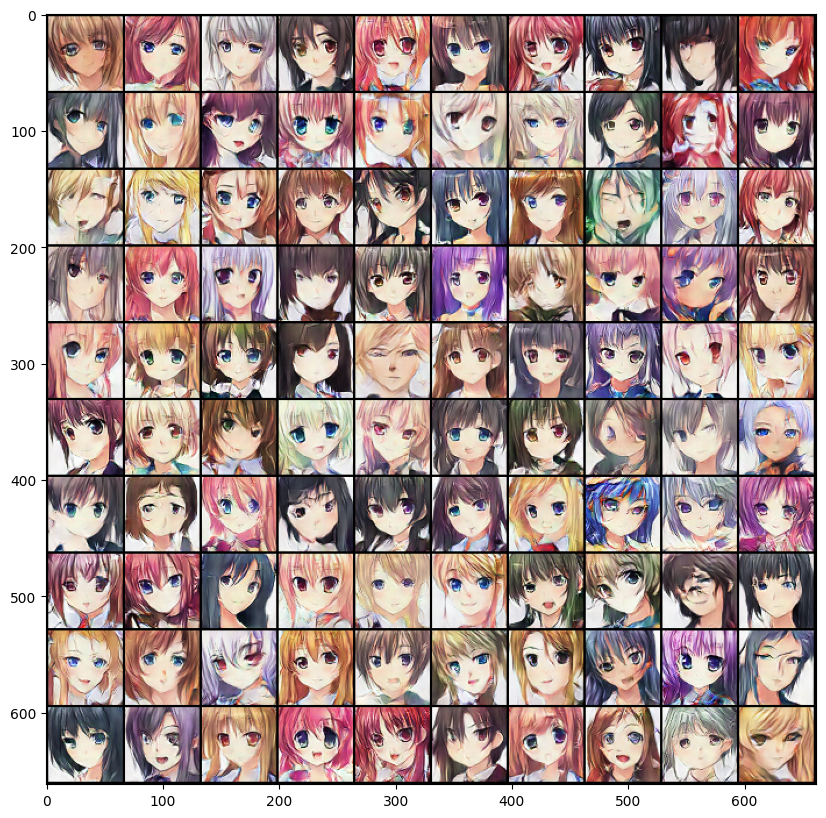

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  progress_bar = qqdm(dataloader)
  # For each batch in the dataloader
  for i, data in enumerate(progress_bar):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    # Output training stats\
    # Set the info of the progress bar
    # Note that the value of the GAN loss is not directly related to
    # the quality of the generated images.
    progress_bar.set_infos({
        'Loss_D': round(errD.item(), 4),
        'Loss_G': round(errG.item(), 4),
        'Epoch': epoch+1,
        'Step': iters,
    })


    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    iters += 1

  # Save generated image with fixed noise in each epoch
  netG.eval()
  f_imgs_sample = (netG(fixed_noise).data + 1) / 2.0
  filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
  torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
  print(f' | Save some samples to {filename}.')

  # Show generated images in the notebook and save in img_list for later use.
  if (epoch+1) % 100 == 0 or epoch == 0:
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    img_list.append(grid_img);
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
  netG.train()

  # Save the checkpoints.
  if (epoch+1) % 5 == 0 or epoch == 0:
    torch.save(netG.state_dict(), os.path.join(ckpt_dir, 'netG.pth'))
    torch.save(netD.state_dict(), os.path.join(ckpt_dir, 'netD.pth'))
    
  torch.cuda.empty_cache()
    


### Plot loss

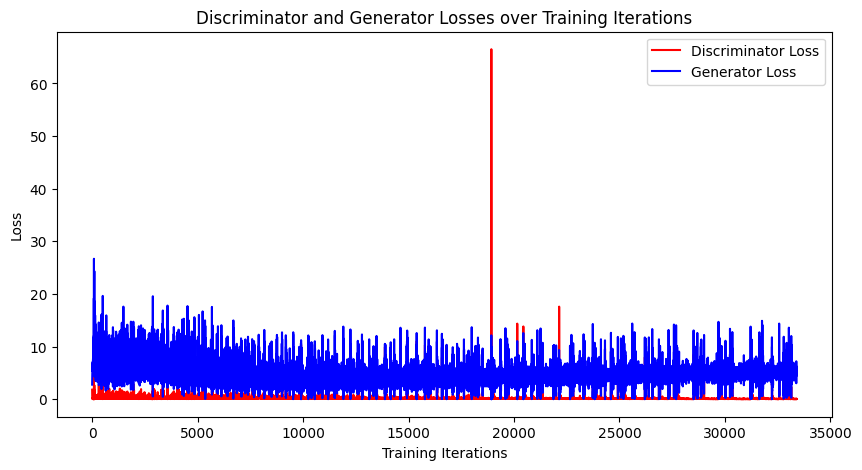

In [16]:
##########################################################################
# TODO: Plot the loss value of discriminator and generator
# Implementation A.1-2
##########################################################################
# the code is reference from : https://stackoverflow.com/questions/65789963/matplotlib-not-showing-training-testing-loss-accuracy-curves
""" D & G’s losses versus training iterations. """
integer_list = list(range(1, iters + 1))
# Plotting the losses versus training iterations
plt.figure(figsize=(10, 5))
plt.plot(integer_list, D_losses, label='Discriminator Loss', color='red')
plt.plot(integer_list, G_losses, label='Generator Loss', color='blue')

# Adding labels and title
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses over Training Iterations')
plt.legend()
plt.savefig('loss.png')
# Display the plot
plt.show()


### Real Images vs. Fake Images

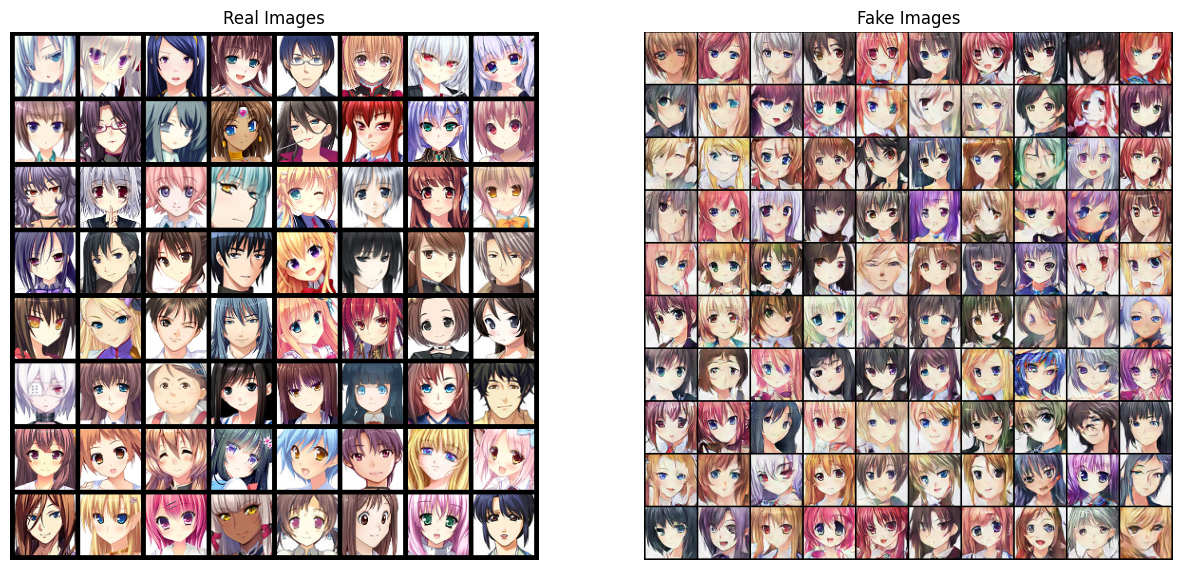

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [18]:
!ls checkpoints

netD.pth  netG.pth


# Inference

The trained model should has been saved in the directory(ckpt_dir) you specified.

Use the trained model to generate images!

### Load model


In [19]:
import torch

# load gernerator
device = torch.device("cuda")
netG = Generator(ngpu)
netG.load_state_dict(torch.load(os.path.join(ckpt_dir, 'netG.pth')))
netG.eval()
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Generate and show images

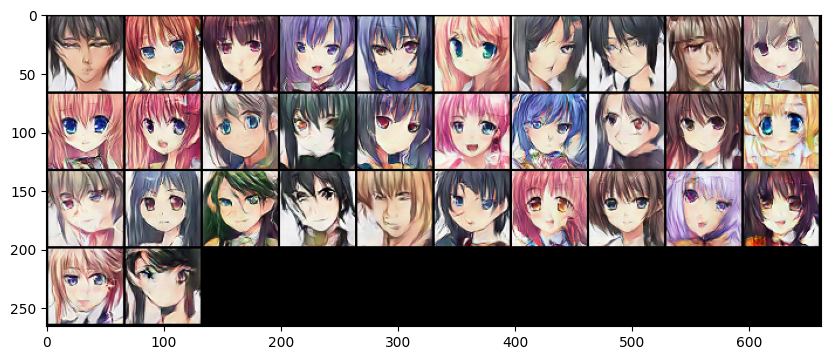

In [20]:
# Generate 100 images and make a grid to save them.
n_output = 100
fixed_noise = torch.randn(100, nz, 1, 1, device=device)
imgs_sample = (netG(fixed_noise).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images in notebook.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using tar

In [21]:
# Save the generated images in archive.
os.makedirs('output', exist_ok=True)
for i in range(n_output):
  torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')

# Compress the images.
#%cd output
#!tar -zcf ../images.tgz *.jpg
#%cd ..

### Plot generated images in 5*5 grid

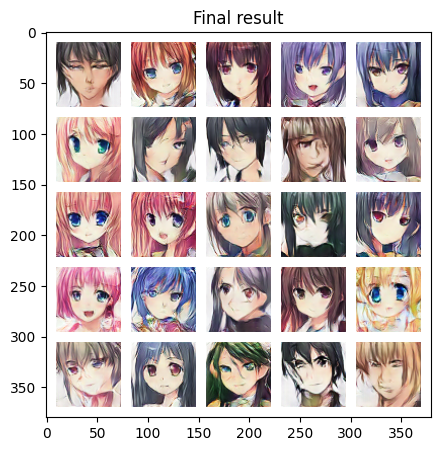

In [22]:
##########################################################################
# TODO: Store your generate images in 5*5 Grid
# Implementation A.1-3
##########################################################################

grid_img = torchvision.utils.make_grid(imgs_sample[:25].cpu(), nrow=5, padding=10, pad_value=1.0)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('Final result')
plt.savefig('5x5grid.png')
plt.show()


### Interpolation
Explore latent space: Interpolation 3 pairs of z vectors and plot generated images in 3*10 grid.

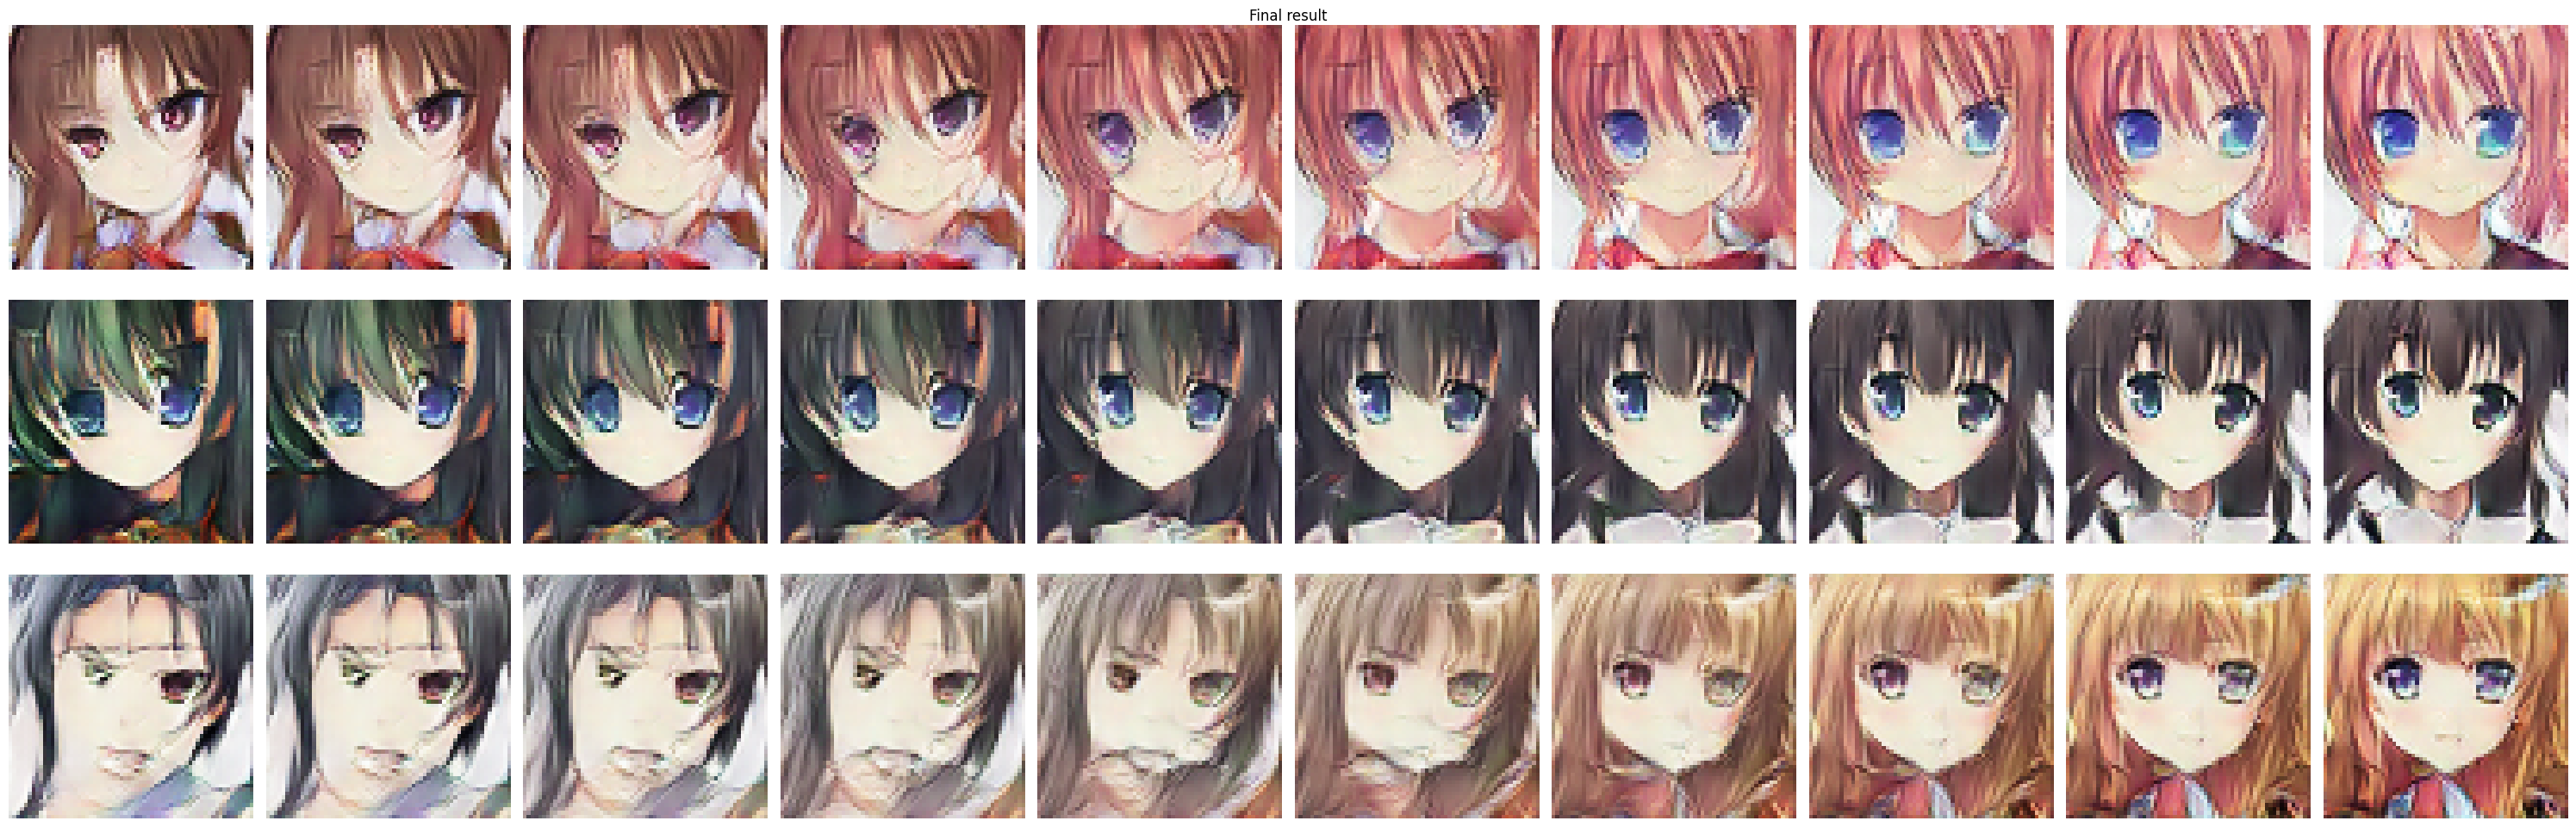

In [23]:
##########################################################################
# TODO: Interpolation 3 pairs of z vectors and plot a 3*10 image.
# Implementation A.1-4
##########################################################################
# Interpolation
plt.figure(figsize=(30, 10))
for i in range(3):
    # Interpolate between two random z vectors
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)
    for j, alpha in enumerate(np.linspace(0, 1, 10)):
        z_interpolate = (1 - alpha) * z1 + alpha * z2
        generated_image = netG(z_interpolate).squeeze().detach().cpu().numpy()
        plt.subplot(3, 10, i * 10 + j + 1)
        plt.axis("off")
        plt.imshow(np.transpose((generated_image + 1) / 2, (1, 2, 0)))
plt.tight_layout()
plt.suptitle('Final result')
plt.savefig('interpolation_result.png')
plt.show()




# IS and fid score

In [47]:
!pip install pytorch-fid

from pytorch_fid import fid_score

# FID
real_images_path = '/kaggle/working/anime_face_dataset/data'
fake_images_path = '/kaggle/working/output'

fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size=64, dims=64, device='cuda')  # 根據你的需要設置 device
print("FID Score:", fid_value)


NameError: name 'Variable' is not defined